In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [2]:

# Load the dataset
df = pd.read_csv('rice_anomaly_complete_dataset.csv')

In [3]:
df.head()

,count,State,Crop_Year,Unnamed: 3,Crop,Season,Area,Production,Annual_Rainfall,Fertilizer,...,DTR,EVI,FPAR,LAI,NDMI,NDVI,VHI,Yield,Avg_Yield,Yield_Anomaly
0,1,Andhra Pradesh,2000,NaN,rice,kharif,3003673.0,8233806.0,935.6,294870578.4,...,10.292866,0.319294,0.343458,0.949356,0.514171,0.498724,0.600056,2.700000,2.894435,-0.194435
1,2,Andhra Pradesh,2001,NaN,rice,kharif,2426073.0,6500545.0,928.4,247774835.5,...,8.781375,0.281821,0.341458,0.953399,0.518244,0.434133,0.588213,2.627273,2.894435,-0.267163
2,3,Andhra Pradesh,2002,NaN,rice,kharif,2109301.0,5054013.0,648.1,199687525.7,...,11.031803,0.301316,0.337381,0.903096,0.517480,0.463705,0.545697,2.202727,2.894435,-0.691708
3,4,Andhra Pradesh,2003,NaN,rice,kharif,2108904.0,5841539.0,826.0,208739317.9,...,9.464396,0.308267,0.324383,0.887312,0.520489,0.479109,0.576954,2.670909,2.894435,-0.223526
4,5,Andhra Pradesh,2004,NaN,rice,kharif,2215067.0,6392717.0,781.8,239980358.8,...,9.593678,0.323230,0.356008,0.978221,0.513606,0.498857,0.599404,2.720455,2.894435,-0.173981


In [4]:
df = df.sort_values('Crop_Year')


# Define the input and target variables
features = ['Crop_Year','VHI', 'DTR', 'NDVI', 'NDMI', 'EVI', 'LAI', 'FPAR', 
            'Precipitation_val', 'Temperature_val', 'Fertilizer', 
            'Pesticide', 'Annual_Rainfall']
target = 'Yield'

# Splitting the train/test based on temporal properties
# I have taken this approach due to the fact that my primary goal was to train an early warning model that could predict rice yield anomaly in advance
test_ = df[df['Crop_Year']>2015]
train_ = df[df['Crop_Year']<=2015]

# Drop rows with missing values in the selected features or target
test_.dropna(subset=features + [target], inplace=True)
train_.dropna(subset=features + [target], inplace=True)

X_train = train_[features]
X_test = test_[features]
y_train = train_[target]
y_test = test_[target]

C:\Users\RezJalali\AppData\Local\Temp\ipykernel_28544\3499460222.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_.dropna(subset=features + [target], inplace=True)
C:\Users\RezJalali\AppData\Local\Temp\ipykernel_28544\3499460222.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_.dropna(subset=features + [target], inplace=True)


In [7]:


# Define the 4 hyperparameter sets
hyperparameter_sets = [
    {'n_estimators': 100, 'max_depth': 5},
    {'n_estimators': 100, 'max_depth': 10},
    {'n_estimators': 200, 'max_depth': None},
    {'n_estimators': 300, 'max_depth': 20},
    {'n_estimators': 500, 'max_depth': 5}
]

# Create a list to store the results
results = []

# Train and evaluate a model for each hyperparameter set
for i, params in enumerate(hyperparameter_sets):
    print(f"Training Model {i+1} with hyperparameters: {params}")
    
    # Create a pipeline with a scaler and the random forest model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(random_state=42, **params))
    ])
    
    # Train the pipeline
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate evaluation metrics
    r_2 = pipeline.score(X_test,y_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Store the results
    results.append({
        'Model': f'Model {i+1}',
        'R2' : r_2,
        'MAE': mae,
        'RMSE': rmse,
        'Hyperparameters': params,
        'Pipeline': pipeline
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=['Model','R2' ,'MAE', 'RMSE', 'Hyperparameters'])
print("\n--- Model Performance Comparison ---")
print(results_df)

# Find the best model based on RMSE
best_model_dict = min(results, key=lambda x: x['RMSE'])
best_model = best_model_dict['Pipeline']
best_model_name = best_model_dict['Model']
print(f"\nBest Model: {best_model_name} (based on lowest RMSE)")


Training Model 1 with hyperparameters: {'n_estimators': 100, 'max_depth': 5}
Training Model 2 with hyperparameters: {'n_estimators': 100, 'max_depth': 10}
Training Model 3 with hyperparameters: {'n_estimators': 200, 'max_depth': None}
Training Model 4 with hyperparameters: {'n_estimators': 300, 'max_depth': 20}
Training Model 5 with hyperparameters: {'n_estimators': 500, 'max_depth': 5}

--- Model Performance Comparison ---
     Model        R2       MAE      RMSE  \
0  Model 1  0.427746  0.387922  0.535797   
1  Model 2  0.375439  0.377663  0.559749   
2  Model 3  0.355050  0.383434  0.568812   
3  Model 4  0.350342  0.385052  0.570885   
4  Model 5  0.394721  0.400232  0.551041   

                            Hyperparameters  
0     {'n_estimators': 100, 'max_depth': 5}  
1    {'n_estimators': 100, 'max_depth': 10}  
2  {'n_estimators': 200, 'max_depth': None}  
3    {'n_estimators': 300, 'max_depth': 20}  
4     {'n_estimators': 500, 'max_depth': 5}  

Best Model: Model 1 (based on 

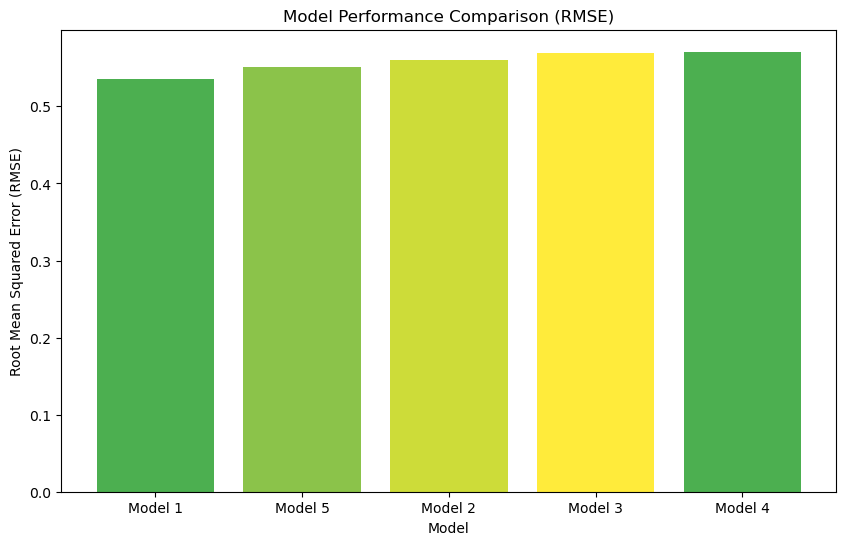

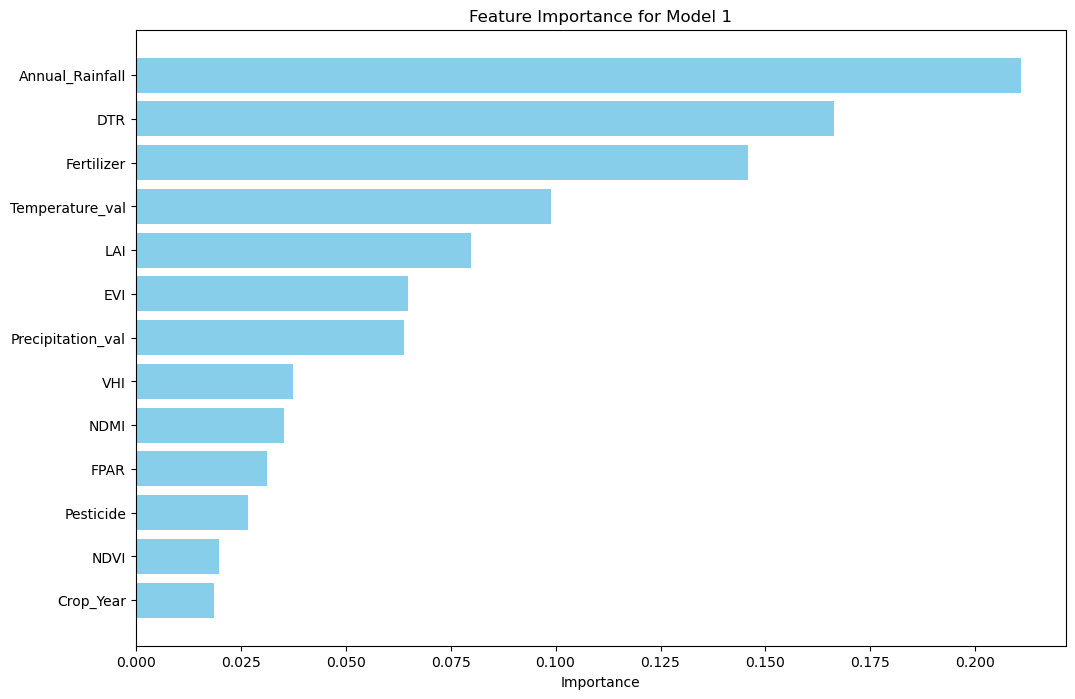

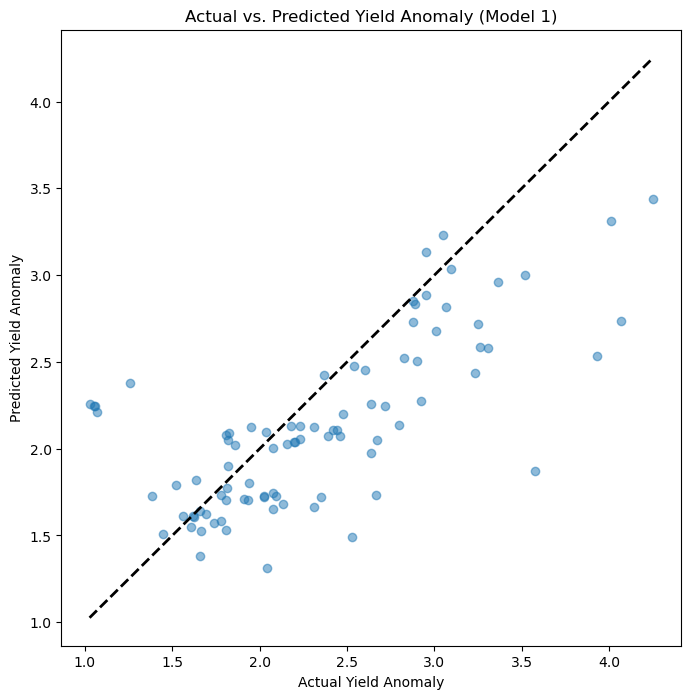

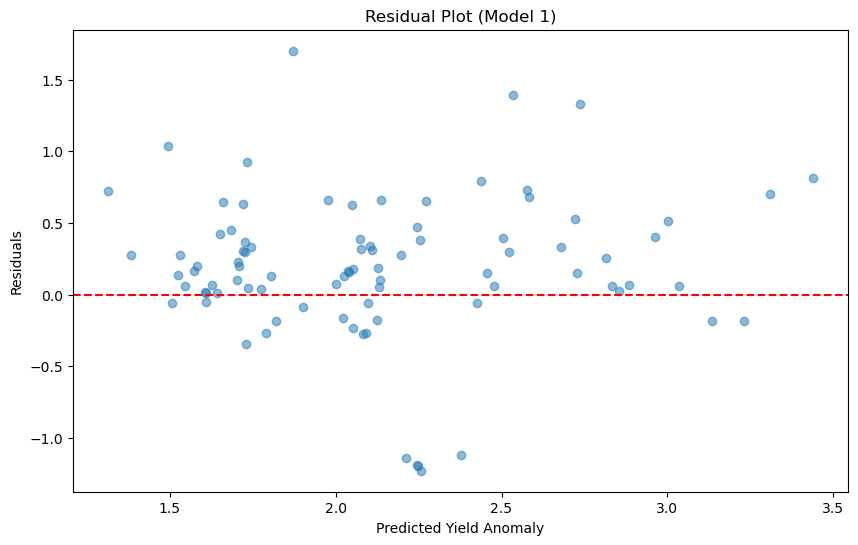

In [8]:

# Bar chart of model performance
fig, ax = plt.subplots(figsize=(10, 6))
results_df.sort_values('RMSE', ascending=True, inplace=True)
ax.bar(results_df['Model'], results_df['RMSE'], color=['#4CAF50', '#8BC34A', '#CDDC39', '#FFEB3B'])
ax.set_ylabel('Root Mean Squared Error (RMSE)')
ax.set_xlabel('Model')
ax.set_title('Model Performance Comparison (RMSE)')
plt.savefig('model_performance_comparison.png')


# Get feature importances from the best model
feature_importances = best_model.named_steps['rf'].feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title(f'Feature Importance for {best_model_name}')
plt.gca().invert_yaxis()
plt.savefig('feature_importance.png')


# Actual vs. Predicted Plot for the best model
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Yield Anomaly')
plt.ylabel('Predicted Yield Anomaly')
plt.title(f'Actual vs. Predicted Yield Anomaly ({best_model_name})')
plt.savefig('actual_vs_predicted.png')


# Residual Plot for the best model
residuals = y_test - y_pred_best

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Yield Anomaly')
plt.ylabel('Residuals')
plt.title(f'Residual Plot ({best_model_name})')
plt.savefig('residual_plot.png')

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Load the dataset
ds = pd.read_csv('rice_anomaly_complete_dataset.csv')

# Define the input and target variables
features = ['VHI', 'DTR', 'NDVI', 'NDMI', 'EVI', 'LAI', 'FPAR', 
            'Precipitation_val', 'Temperature_val', 'Fertilizer', 
            'Pesticide', 'Annual_Rainfall']
original_target = 'Yield_Anomaly'
new_target = 'Anomaly_Class'

# Create the new categorical target variable based on rice yield anomaly values
ds['Anomaly_Class'] = np.where(ds[original_target] < 0, 'Stressed', 'Not_Stressed')

# --- Time-Based Data Split
test_2 = ds[ds['Crop_Year'] > 2015].copy()
train_2 = ds[ds['Crop_Year'] <= 2015].copy()

# Drop rows with missing values to avoid errors during training
test_2.dropna(subset=features + [new_target], inplace=True)
train_2.dropna(subset=features + [new_target], inplace=True)

X_train = train_2[features]
X_test = test_2[features]
y_train = train_2[new_target]
y_test = test_2[new_target]


# --- Define Hyperparameter Sets ---
# Note: Using the same sets from our initial regression task
hyperparameter_sets = [
    {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2},
    {'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5},
    {'n_estimators': 300, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10},
    {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 20}
]

# --- Train and Evaluate Multiple RandomForestClassifiers ---
print("Training and Evaluating Classifiers...")
classify_results = []

for i, params in enumerate(hyperparameter_sets):
    print(f"\n--- Training Model {i+1} with hyperparameters: {params} ---")
    
    # Create a pipeline with a scaler and the random forest classifier
    classifier_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rfc', RandomForestClassifier(random_state=42, **params))
    ])
    
    # Train the pipeline
    classifier_pipeline.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_class = classifier_pipeline.predict(X_test)
    
    # Evaluate the Classifier
    accuracy = accuracy_score(y_test, y_pred_class)
    cm = confusion_matrix(y_test, y_pred_class)
    
    print(f"Model Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_class, zero_division=0))
    
    # Store results
    classify_results.append({
        'Model': f'Model {i+1}',
        'Accuracy': accuracy,
        'Confusion Matrix': cm,
        'Hyperparameters': params,
        'Pipeline': classifier_pipeline # Corrected this line
    })

# Convert results to a DataFrame for easy viewing
classify_results_df = pd.DataFrame(classify_results, columns=['Model', 'Accuracy', 'Hyperparameters'])
print("\n--- Overall Model Performance Comparison ---")
print(classify_results_df)

# Find the best model based on Accuracy
best_model_dict = max(classify_results, key=lambda x: x['Accuracy'])
best_model_pipeline = best_model_dict['Pipeline']
best_model_name = best_model_dict['Model']
print(f"\nBest Model: {best_model_name} (based on Highest Accuracy)")



Training and Evaluating Classifiers...

--- Training Model 1 with hyperparameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2} ---
Model Accuracy: 0.6364
Classification Report:
              precision    recall  f1-score   support

Not_Stressed       0.87      0.65      0.75        72
    Stressed       0.26      0.56      0.36        16

    accuracy                           0.64        88
   macro avg       0.57      0.61      0.55        88
weighted avg       0.76      0.64      0.68        88


--- Training Model 2 with hyperparameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5} ---
Model Accuracy: 0.6250
Classification Report:
              precision    recall  f1-score   support

Not_Stressed       0.87      0.64      0.74        72
    Stressed       0.26      0.56      0.35        16

    accuracy                           0.62        88
   macro avg       0.56      0.60      0.54        88


C:\Users\RezJalali\AppData\Local\Temp\ipykernel_28544\531455195.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


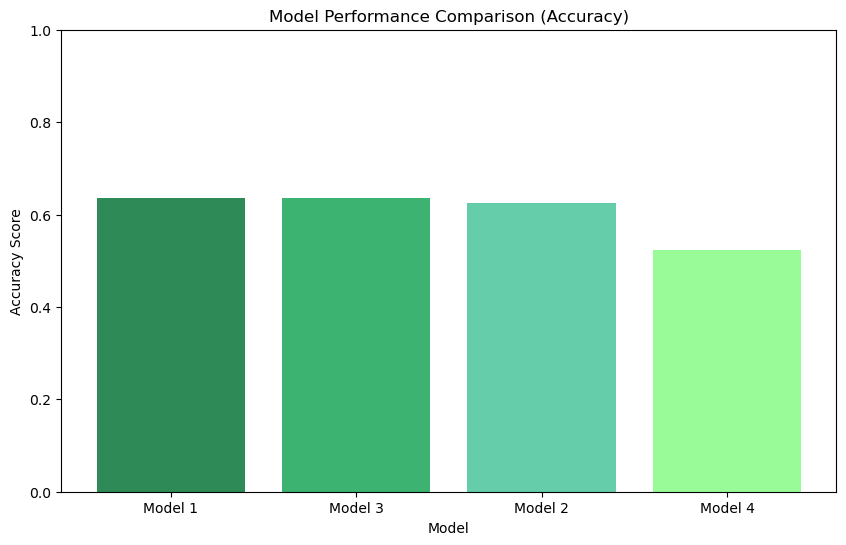

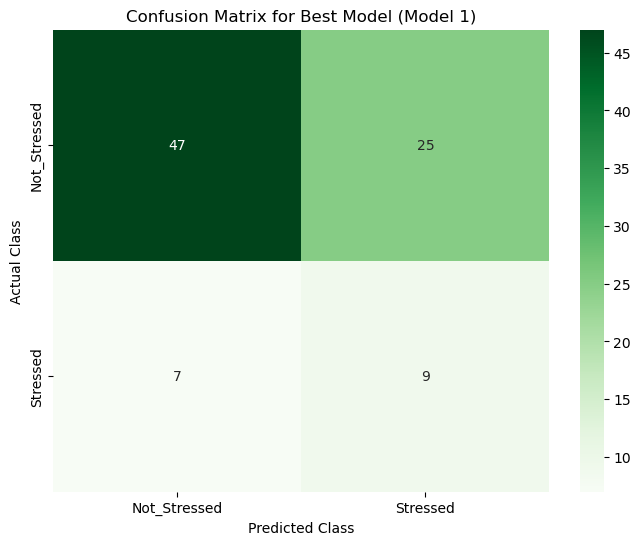

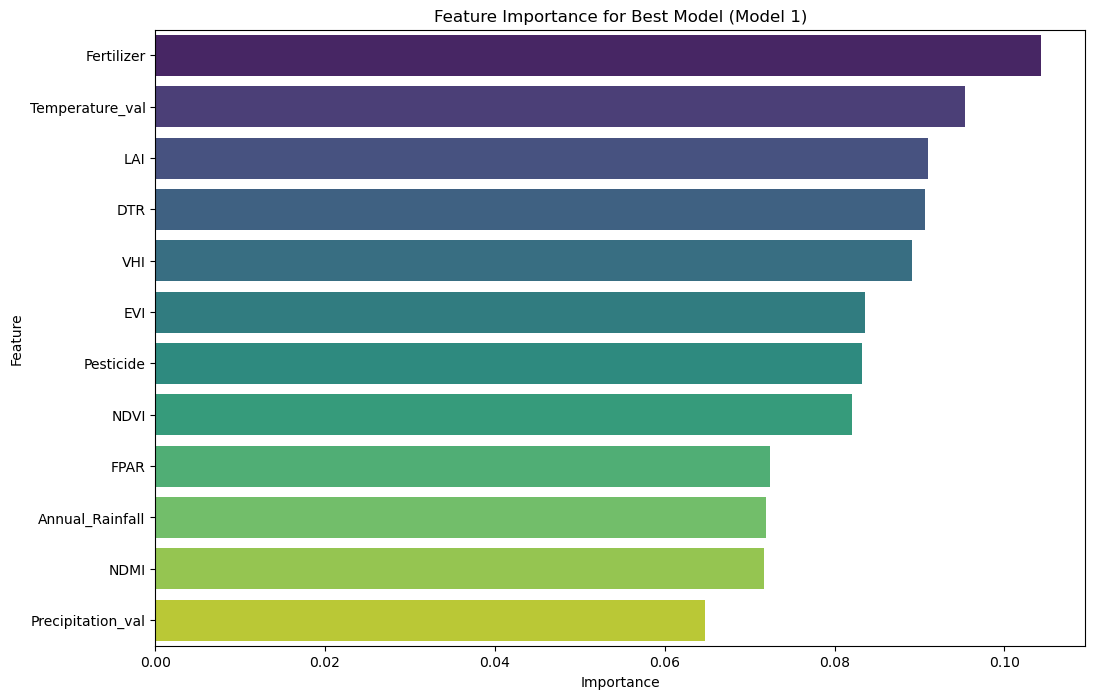

In [15]:

# --- VISUALIZATION BLOCK ---

# 1. Bar chart of model performance (Accuracy)
fig, ax = plt.subplots(figsize=(10, 6))
# Sort by accuracy for a cleaner plot
classify_results_df.sort_values('Accuracy', ascending=False, inplace=True)
ax.bar(classify_results_df['Model'], classify_results_df['Accuracy'], color=['#2E8B57', '#3CB371', '#66CDAA', '#98FB98'])
ax.set_ylabel('Accuracy Score')
ax.set_xlabel('Model')
ax.set_ylim(0, 1.0) # Set y-axis from 0 to 1 for accuracy
ax.set_title('Model Performance Comparison (Accuracy)')
plt.savefig('classifier_accuracy_comparison.png')


# 2. Confusion Matrix for the BEST model
best_cm = best_model_dict['Confusion Matrix']
plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=best_model_pipeline.classes_, yticklabels=best_model_pipeline.classes_)
plt.title(f'Confusion Matrix for Best Model ({best_model_name})')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.savefig('best_classifier_confusion_matrix.png')


# 3. Feature Importance for the BEST model
best_feature_importances = best_model_pipeline.named_steps['rfc'].feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': best_feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Feature Importance for Best Model ({best_model_name})')
plt.savefig('best_classifier_feature_importance.png')

plt.show()

Training and Evaluating Cost-Sensitive Classifiers...

--- Training Model 1 with hyperparameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2} ---
Model Accuracy: 0.6250
Weighted F1-Score: 0.6664
Classification Report:
              precision    recall  f1-score   support

Not_Stressed       0.87      0.64      0.74        72
    Stressed       0.26      0.56      0.35        16

    accuracy                           0.62        88
   macro avg       0.56      0.60      0.54        88
weighted avg       0.76      0.62      0.67        88


--- Training Model 2 with hyperparameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5} ---
Model Accuracy: 0.6591
Weighted F1-Score: 0.6946
Classification Report:
              precision    recall  f1-score   support

Not_Stressed       0.88      0.68      0.77        72
    Stressed       0.28      0.56      0.38        16

    accuracy                           0.

C:\Users\RezJalali\AppData\Local\Temp\ipykernel_28544\450809465.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')


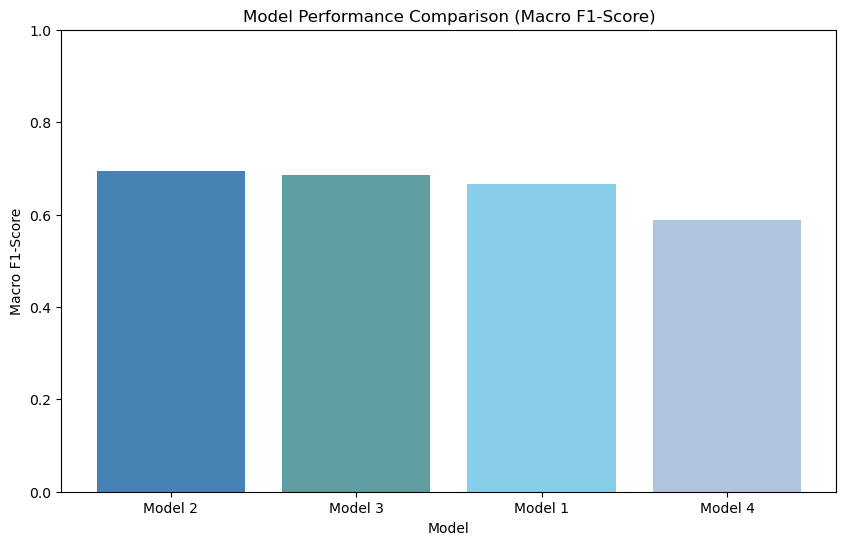

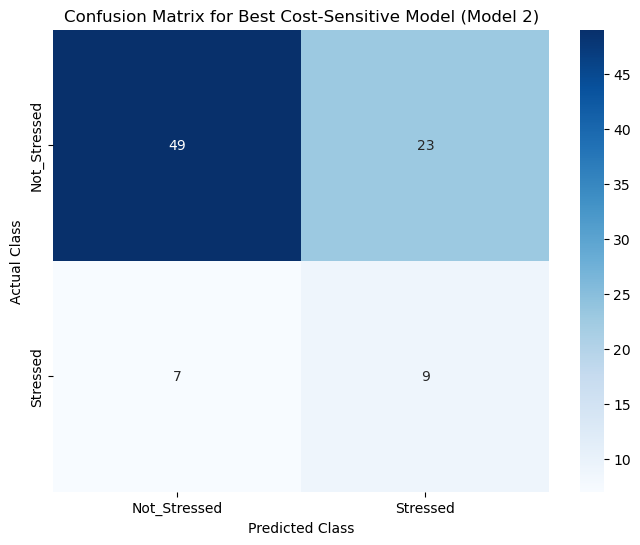

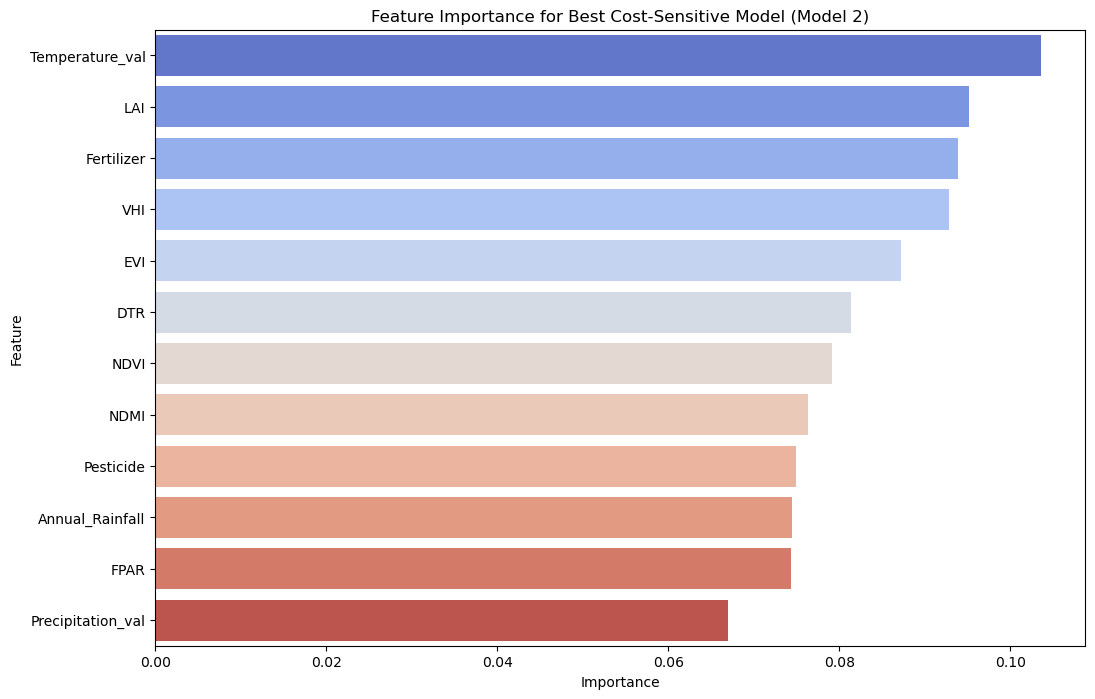

In [17]:
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)


# Create the new categorical target variable
ds['Anomaly_Class'] = np.where(ds[original_target] < 0, 'Stressed', 'Not_Stressed')

# --- Time-Based Data Split ---
test_2 = ds[ds['Crop_Year'] > 2015].copy()
train_2 = ds[ds['Crop_Year'] <= 2015].copy()

# Drop rows with missing values
test_2.dropna(subset=features + [new_target], inplace=True)
train_2.dropna(subset=features + [new_target], inplace=True)

X_train = train_2[features]
X_test = test_2[features]
y_train = train_2[new_target]
y_test = test_2[new_target]

# --- Define Hyperparameter Sets ---
hyperparameter_sets = [
    {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2},
    {'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5},
    {'n_estimators': 300, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10},
    {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 20}
]

# --- Train and Evaluate Cost-Sensitive Classifiers ---
print("Training and Evaluating Cost-Sensitive Classifiers...")
classify_results = []

for i, params in enumerate(hyperparameter_sets):
    print(f"\n--- Training Model {i+1} with hyperparameters: {params} ---")
    
    # Create a pipeline with a scaler and the cost-sensitive random forest classifier
    classifier_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        # --- KEY CHANGE: Added class_weight='balanced' ---
        ('rfc', RandomForestClassifier(random_state=42, class_weight='balanced', **params))
    ])
    
    # Train the pipeline
    classifier_pipeline.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_class = classifier_pipeline.predict(X_test)
    
    # Evaluate the Classifier
    accuracy = accuracy_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class, average='weighted')
    cm = confusion_matrix(y_test, y_pred_class)
    report = classification_report(y_test, y_pred_class, zero_division=0)
    
    print(f"Model Accuracy: {accuracy:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("Classification Report:")
    print(report)
    
    # Store results
    classify_results.append({
        'Model': f'Model {i+1}',
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Confusion Matrix': cm,
        'Pipeline': classifier_pipeline
    })

# Convert results to a DataFrame for easy viewing
classify_results_df = pd.DataFrame(classify_results, columns=['Model', 'Accuracy', 'F1-Score'])
print("\n--- Overall Model Performance Comparison ---")
print(classify_results_df)

# Find the best model based on Macro F1-Score for balanced performance
best_model_dict = max(classify_results, key=lambda x: x['F1-Score'])
best_model_pipeline = best_model_dict['Pipeline']
best_model_name = best_model_dict['Model']
print(f"\nBest Model: {best_model_name} (based on Highest Macro F1-Score)")


# --- VISUALIZATION BLOCK ---

# 1. Bar chart of model performance (F1-Score)
fig, ax = plt.subplots(figsize=(10, 6))
classify_results_df.sort_values('F1-Score', ascending=False, inplace=True)
ax.bar(classify_results_df['Model'], classify_results_df['F1-Score'], color=['#4682B4', '#5F9EA0', '#87CEEB', '#B0C4DE'])
ax.set_ylabel('Macro F1-Score')
ax.set_xlabel('Model')
ax.set_ylim(0, 1.0)
ax.set_title('Model Performance Comparison (Macro F1-Score)')
plt.savefig('costsensive_f1_comparison.png')

# 2. Confusion Matrix for the BEST model
best_cm = best_model_dict['Confusion Matrix']
plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_model_pipeline.classes_, yticklabels=best_model_pipeline.classes_)
plt.title(f'Confusion Matrix for Best Cost-Sensitive Model ({best_model_name})')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.savefig('costsensive_best_confusion_matrix.png')

# 3. Feature Importance for the BEST model
best_feature_importances = best_model_pipeline.named_steps['rfc'].feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': best_feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Feature Importance for Best Cost-Sensitive Model ({best_model_name})')
plt.savefig('costsensive_best_feature_importance.png')

plt.show()

In [18]:
train_2.head()

,count,State,Crop_Year,Unnamed: 3,Crop,Season,Area,Production,Annual_Rainfall,Fertilizer,...,EVI,FPAR,LAI,NDMI,NDVI,VHI,Yield,Avg_Yield,Yield_Anomaly,Anomaly_Class
0,1,Andhra Pradesh,2000,NaN,rice,kharif,3003673.0,8233806.0,935.6,294870578.4,...,0.319294,0.343458,0.949356,0.514171,0.498724,0.600056,2.700000,2.894435,-0.194435,Stressed
1,2,Andhra Pradesh,2001,NaN,rice,kharif,2426073.0,6500545.0,928.4,247774835.5,...,0.281821,0.341458,0.953399,0.518244,0.434133,0.588213,2.627273,2.894435,-0.267163,Stressed
2,3,Andhra Pradesh,2002,NaN,rice,kharif,2109301.0,5054013.0,648.1,199687525.7,...,0.301316,0.337381,0.903096,0.517480,0.463705,0.545697,2.202727,2.894435,-0.691708,Stressed
3,4,Andhra Pradesh,2003,NaN,rice,kharif,2108904.0,5841539.0,826.0,208739317.9,...,0.308267,0.324383,0.887312,0.520489,0.479109,0.576954,2.670909,2.894435,-0.223526,Stressed
4,5,Andhra Pradesh,2004,NaN,rice,kharif,2215067.0,6392717.0,781.8,239980358.8,...,0.323230,0.356008,0.978221,0.513606,0.498857,0.599404,2.720455,2.894435,-0.173981,Stressed


In [20]:
df.columns

Index(['count', 'State', 'Crop_Year', 'Unnamed: 3', 'Crop', 'Season', 'Area',
       'Production', 'Annual_Rainfall', 'Fertilizer', 'Pesticide',
       'Precipitation_val', 'Temperature_val', 'DTR', 'EVI', 'FPAR', 'LAI',
       'NDMI', 'NDVI', 'VHI', 'Yield', 'Avg_Yield', 'Yield_Anomaly'],
      dtype='object')

In [21]:
corr_df = df.loc[:,['Annual_Rainfall','Fertilizer','Pesticide','Precipitation_val','Temperature_val','DTR','EVI', 'FPAR', 'LAI',
       'NDMI', 'NDVI', 'VHI', 'Yield', 'Yield_Anomaly']]

In [28]:
corr_X = corr_df.corr(method='spearman')

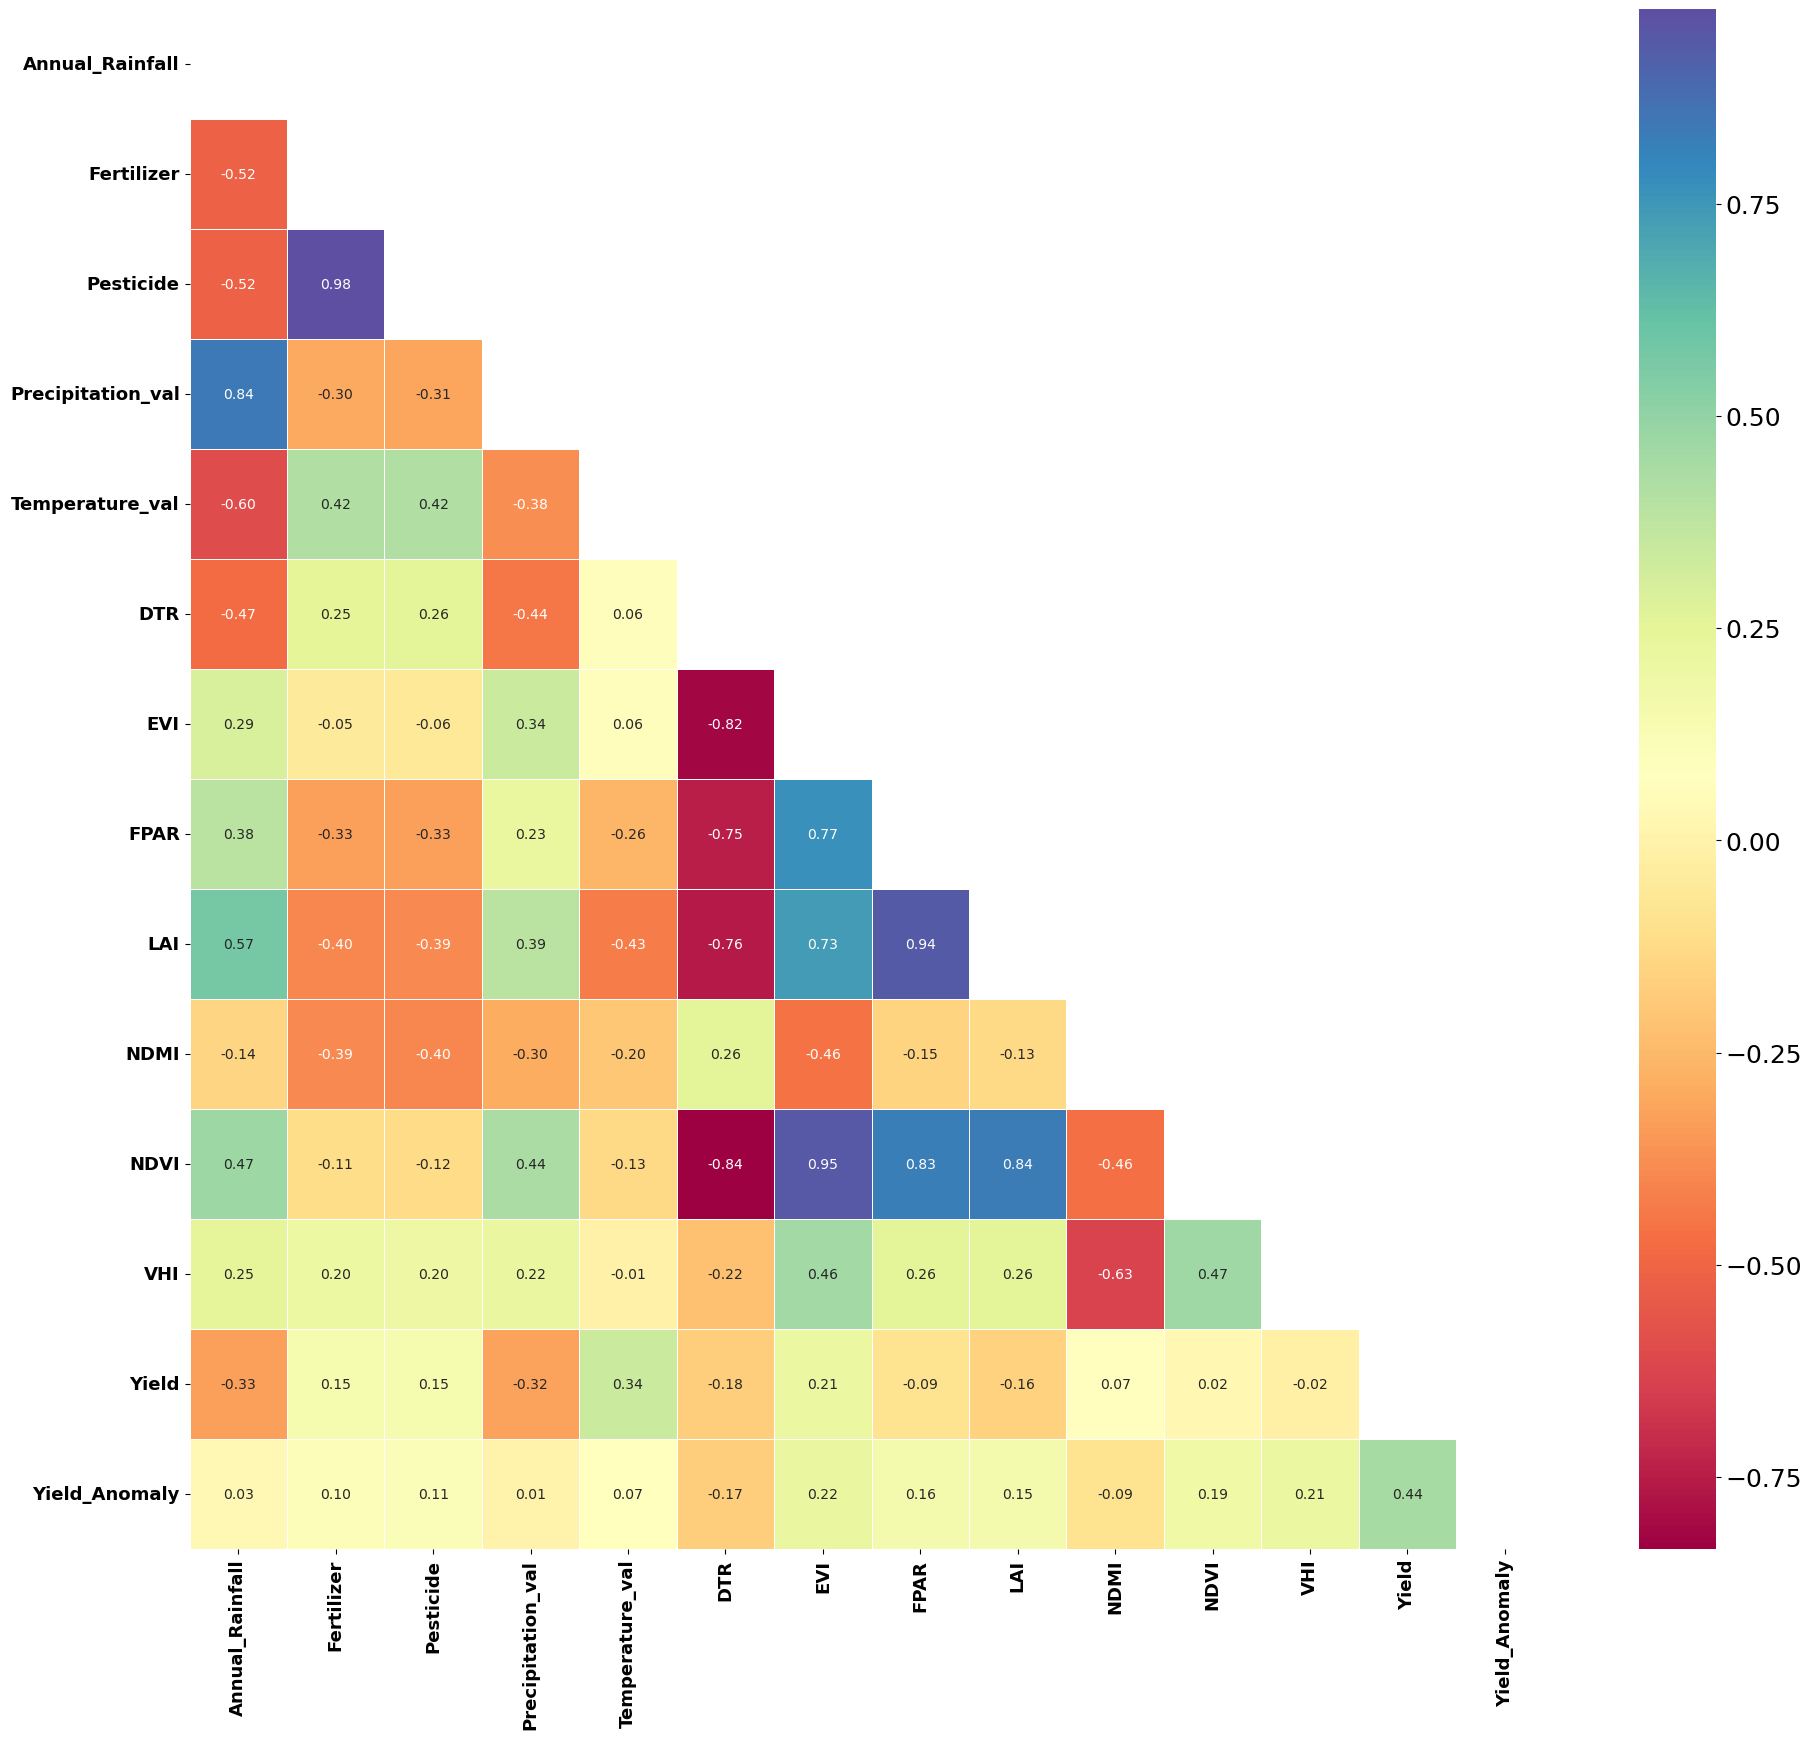

In [30]:
plt.figure(figsize=(22,20))
mask = np.zeros_like(corr_X)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr_X, fmt= '.2f', cmap='Spectral', mask=mask,linewidths=0.5,annot=True)
plt.xticks(fontweight='extra bold',fontsize=13)
plt.yticks(fontweight='extra bold',fontsize=13)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)
plt.savefig('corr_heatmap.png',dpi=300)
plt.show()

Starting Sequential Forward Selection...
SFS Completed.

Best 6 Features:
('VHI', 'NDVI', 'NDMI', 'EVI', 'LAI', 'Temperature_val')

F1-Score with best 6 features:
0.5447215214918898

Detailed SFS Results:
                               feature_idx  \
12  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)   
11      (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11)   
10         (0, 1, 2, 3, 4, 5, 6, 8, 9, 11)   
9             (0, 1, 2, 3, 4, 5, 6, 8, 11)   
8                 (0, 1, 2, 3, 4, 5, 6, 8)   
7                    (0, 2, 3, 4, 5, 6, 8)   
6                       (0, 2, 3, 4, 5, 8)   

                                            cv_scores avg_score  \
12  [0.5390476190476191, 0.3406829729410375, 0.297...  0.436743   
11  [0.5700106345267636, 0.42670401493930904, 0.33...   0.47511   
10  [0.5700106345267636, 0.5142857142857142, 0.297...  0.475442   
9   [0.6, 0.5030367481980386, 0.3661904761904762, ...  0.496464   
8   [0.5966666666666667, 0.5679185679185679, 0.366...  0.503862   
7   [0.5966666666666667,

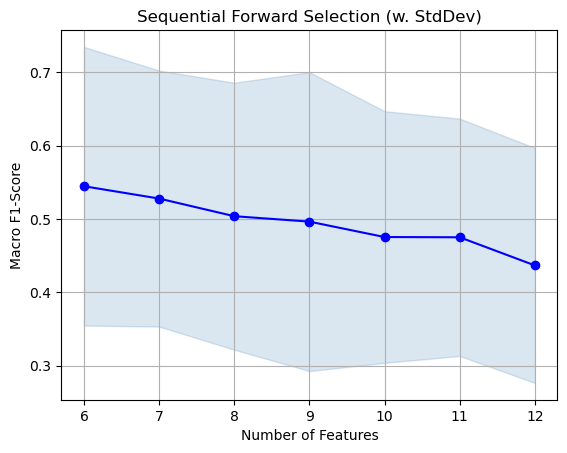

In [35]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# --- 2. Define the Estimator ---
# Use the best hyperparameters from our last cost-sensitive model (Model 2)
best_params = {'n_estimators': 200, 'max_depth': 5}

# Create the cost-sensitive Random Forest classifier pipeline
# This pipeline will be evaluated by the SFS
classifier_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier(
        random_state=42, 
        class_weight='balanced', 
        **best_params
    ))
])


# --- 3. Perform Sequential Forward Selection ---
# Initialize SFS
sfs = SFS(
    estimator=classifier_pipeline, 
    k_features=6,  # We want to select the best 6 features
    forward=False, 
    floating=False, 
    scoring='f1_weighted',  # Use macro F1-score to handle imbalance
    cv=10,                # Use 5-fold cross-validation
    n_jobs=-1            # Use all available CPU cores
)

print("Starting Sequential Forward Selection...")
# Fit SFS on the training data
sfs.fit(X_train, y_train)
print("SFS Completed.")


# --- 4. View the Results ---
# Print the names of the 6 selected features
print('\nBest 6 Features:')
print(sfs.k_feature_names_)

# Print the performance of the model with the best 6 features
print('\nF1-Score with best 6 features:')
print(sfs.k_score_)

# You can also view the results as a DataFrame
sfs_results_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
print('\nDetailed SFS Results:')
print(sfs_results_df)


# --- 5. Visualize the Results ---
print('\nGenerating visualization...')
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.ylabel('Macro F1-Score')
plt.grid()
plt.savefig('sfs_performance_plot.png')
print("Plot saved as 'sfs_performance_plot.png'")
plt.show()